In [19]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
from PIL import Image
from scipy import ndimage
import pandas as pd
import imageio
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16

from datetime import datetime
from packaging import version

%matplotlib inline

In [20]:
# Preprocessing Functions
def convert_to_indices(arr, binsPower):
    arr = np.around(arr, decimals=binsPower)
    arr = np.multiply(arr, 10**(binsPower))
    return arr.astype(int)

def onehot_initialization(a, binsPower):
    ncols = 10 **(binsPower) + 1
    out = np.zeros(a.shape + (ncols,), dtype=int)
    out[all_idx(a, axis=2)] = 1
    return out

def all_idx(idx, axis):
    grid = np.ogrid[tuple(map(slice, idx.shape))]
    grid.insert(axis, idx)
    return tuple(grid)

def convert_onehot(arr, binPower):
    arr = convert_to_indices(arr, binPower)
    arr = onehot_initialization(arr, binPower)
    return arr

In [21]:
labels = pd.read_csv('labels.csv', float_precision='road_trip')
labels.head(5)

,Unnamed: 0,img_name,base,base color R,base color G,base color B,specular,specular color R,specular color G,specular color B,specular roughness,metalness
0,0,0.bmp,0.196696,[0.02551167982996516,0.523569,0.09533690194549593],0.903675,[0.9414576345001383,0.927580,0.418087362819755],0.120439,0.941755
1,1,1.bmp,0.563387,[0.13560656102894886,0.715835,0.6311335628961977],0.381407,[0.9228773407900674,0.328530,0.294482323738513],0.439152,0.511734
2,2,2.bmp,0.433630,[0.06292513279208145,0.468129,0.49781547380782],0.622876,[0.8260393377700712,0.115993,0.1549741111822439],0.646591,0.490058
3,3,3.bmp,0.471443,[0.8909351516333082,0.133360,0.7187711144029106],0.419356,[0.08579008506320773,0.466882,0.36951439970192435],0.154928,0.632136
4,4,4.bmp,0.172493,[0.1089380911674539,0.179026,0.4079338804909298],0.893968,[0.9620524644071147,0.906355,0.3523653506316685],0.708425,0.002353


In [22]:
labels["base color R"] = labels["base color R"].str[1:]
labels["base color B"] = labels["base color B"].str[:-1]
labels["specular color R"] = labels["specular color R"].str[1:]
labels["specular color B"] = labels["specular color B"].str[:-1]
labels["img_name"] = labels["img_name"].str[:-3]+"jpg"

In [23]:
labels.head(5)

,Unnamed: 0,img_name,base,base color R,base color G,base color B,specular,specular color R,specular color G,specular color B,specular roughness,metalness
0,0,0.jpg,0.196696,0.02551167982996516,0.523569,0.09533690194549593,0.903675,0.9414576345001383,0.927580,0.418087362819755,0.120439,0.941755
1,1,1.jpg,0.563387,0.13560656102894886,0.715835,0.6311335628961977,0.381407,0.9228773407900674,0.328530,0.294482323738513,0.439152,0.511734
2,2,2.jpg,0.433630,0.06292513279208145,0.468129,0.49781547380782,0.622876,0.8260393377700712,0.115993,0.1549741111822439,0.646591,0.490058
3,3,3.jpg,0.471443,0.8909351516333082,0.133360,0.7187711144029106,0.419356,0.08579008506320773,0.466882,0.36951439970192435,0.154928,0.632136
4,4,4.jpg,0.172493,0.1089380911674539,0.179026,0.4079338804909298,0.893968,0.9620524644071147,0.906355,0.3523653506316685,0.708425,0.002353


In [24]:
vector_values = labels.iloc[:,2:]
vector_values = vector_values.astype(float)

In [25]:
np_labels = vector_values.values
np_labels[0]

array([0.19669609, 0.02551168, 0.52356934, 0.0953369 , 0.90367509,
       0.94145763, 0.92757973, 0.41808736, 0.1204395 , 0.94175506])

In [26]:
onehots = convert_onehot(np_labels, 2)
onehots[0,2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
# check to make sure it works. should equal number of categories (10)
print(np.sum(onehots[0]))

10


In [28]:
print(onehots.shape)

(4000, 10, 101)


(855, 1280, 3)

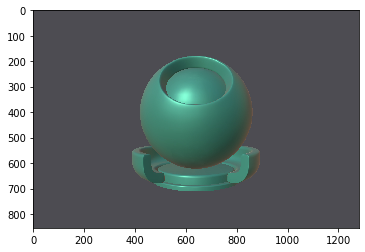

In [29]:
fname = "./data/images/1.jpg"
arr = np.array(imageio.imread(fname))
plt.imshow(arr)
arr.shape

In [30]:
BATCH_SIZE = 40
IMG_HEIGHT = 855
IMG_WIDTH = 1280
STEPS_PER_EPOCH = np.ceil(4000/BATCH_SIZE) 

In [31]:
def crop(img):
    # Note: image_data_format is 'channel_last'
    x = 212
    y = 0
    crop_size = 855
    new_img = tf.image.crop_to_bounding_box(img, 0, 212, crop_size, crop_size)
    return tf.image.resize(new_img, [224, 224])

def label_gen(labels, batch_size):
    num = 0
    while True:
        yield labels[num: num + BATCH_SIZE, :]
        num += batch_size
        if (num >= len(labels)):
            num = 0
    
def crop_generator(batches, labels, crop_length):
    while True:
        batch_x = next(batches)
        labels_x = next(labels)
        start_y = (855 - crop_length) // 2
        start_x = (1280 - crop_length) // 2
        batch_crops = np.zeros((BATCH_SIZE, 224, 224, 3))
        for i in range(batch_crops.shape[0]):
            batch_crops[i] = crop(batch_x[0][i])
        #assert(labels_x.shape[0] == batch_crops.shape[0], "labels size = " + str(labels_x.shape[0]))
        yield (batch_crops, labels_x)
        
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [32]:
# 90 percent split
train_data_gen = image_generator.flow_from_directory(directory=str("./data_split/train_data"),
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle = False,
                                                     classes = None)
test_data_gen = image_generator.flow_from_directory(directory=str("./data_split/test_data"),
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     batch_size=400,
                                                     classes = None)

Found 3600 images belonging to 1 classes.
Found 400 images belonging to 1 classes.


In [33]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

In [34]:
Y_train = np_labels[:3600]
Y_test = np_labels[3600:]
Y_train_gen = label_gen(Y_train, BATCH_SIZE)
Y_test_gen = label_gen(Y_test, 400)

In [47]:
initial_model = VGG16(weights='imagenet', include_top=False)

for layer in initial_model.layers:
    layer.trainable = False

# Version 1 - this flattens the output and passes into a dense 10 layer output
# preds = layers.Flatten()(initial_model.output)
# preds.set_shape((None, 25088))
# preds = layers.Dense(10, activation='sigmoid', input_shape=(None, 25088), trainable=True)(preds)

# Version 2 - this passes the output into:
# a conv layer, tanh activation, spatial dropout, flattens, and into a dense layer
# preds = layers.Conv2D(30, 5, strides=(1, 1), padding='valid', data_format='channels_last') (initial_model.output)
# preds = layers.Activation('tanh')(preds)
# preds = layers.SpatialDropout2D(0.4)(preds)
# preds = layers.Flatten()(preds)
# preds.set_shape((None, 1470))
# preds = layers.Dense(10, activation='sigmoid', input_shape=(None, 1470), trainable=True)(preds)

# Version 3 - this passes the output into:
# a conv layer, tanh activation, another conv layer, spatial dropout, flattens, and into a dense layer
preds = layers.Conv2D(30, 5, strides=(1, 1), padding='valid', data_format='channels_last') (initial_model.output)
preds = layers.Activation('tanh')(preds)
preds = layers.Conv2D(16, 3, strides=(1, 1), padding='valid', data_format='channels_last') (preds)
preds = layers.SpatialDropout2D(0.4)(preds)
preds = layers.Flatten()(preds)
preds.set_shape((None, 1296))
preds = layers.Dense(10, activation='sigmoid', input_shape=(None, 1296), trainable=True)(preds)


model = keras.Model(initial_model.input, preds)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [46]:
train_crops = crop_generator(train_data_gen, Y_train_gen, 855)
test_crops = crop_generator(test_data_gen, Y_test_gen, 855)

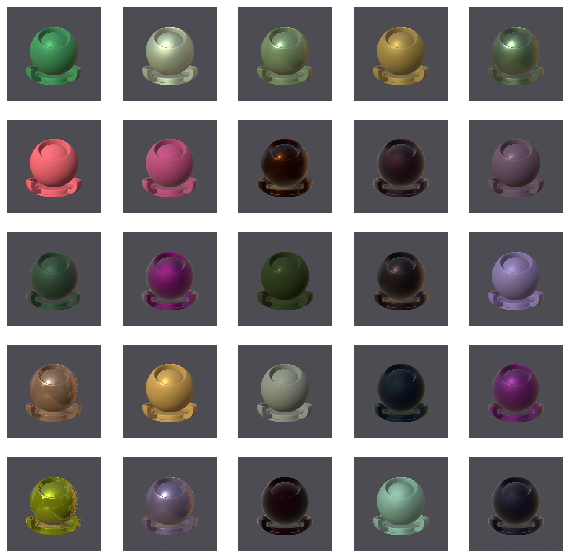

In [43]:
image_batch, label_batch = next(train_crops)
show_batch(image_batch, label_batch)

In [44]:
STEP_SIZE_TRAIN=train_data_gen.n//train_data_gen.batch_size
STEP_SIZE_VALID=test_data_gen.n//test_data_gen.batch_size

model.fit_generator(generator=train_crops,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_crops,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    max_queue_size=10, 
                    workers=1, 
                    use_multiprocessing=False,
                    callbacks=[]
)

Epoch 1/10


KeyboardInterrupt: 